In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_citeseer import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/citeseer/04-1-structural_graphsage_dotmlp_gamma_function.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

In [7]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [8]:
data = prepare_adjencency(data)

## Training

In [9]:
for run in range(10):
    for n_layers_graph_sage in range(1, 4):
        omega = StructuralOmegaGraphSageCosSim(
            device,
            dataset='citeseer',
            in_channels=data.x.shape[1],
            n_layers_graph_sage=n_layers_graph_sage,
            run=run,
            eval_steps=10,
            epochs=2000)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [10]:
n_layers_graph_sage = 2

In [11]:
metrics = StructuralOmegaGraphSageCosSim.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage,
    dataset='citeseer')
print(metrics.shape)
metrics.head()

(2010, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.605771,0.593393,0.574163,0.550025,0.559208,0.517310
1,0,10,0.378846,0.539320,0.535149,0.991615,0.684795,0.680557
2,0,20,0.321028,0.537834,0.536527,0.995576,0.683489,0.666163
3,0,30,0.288988,0.533833,0.544246,0.998910,0.692192,0.665976
4,0,40,0.271524,0.535950,0.542602,0.997666,0.683712,0.649268


### Sumarize metrics per epoch

In [12]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [13]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [14]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.606162,0.001025,0.593572,0.001589,0.573823,0.002073,0.558156,0.013085,0.558249,0.014443,0.548010,0.020447
10,0.378002,0.002539,0.541451,0.003233,0.535343,0.001657,0.992683,0.001683,0.694689,0.012603,0.671581,0.006410
20,0.320317,0.002600,0.543175,0.005918,0.539867,0.003629,0.996001,0.001289,0.684908,0.006964,0.658407,0.009165
30,0.291291,0.002111,0.545687,0.006398,0.544129,0.002658,0.997320,0.000958,0.679956,0.009169,0.659153,0.008575
40,0.272429,0.001842,0.548059,0.006556,0.545841,0.001582,0.998306,0.000479,0.675955,0.013104,0.655721,0.007138


In [15]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
10,0.378002,0.002539,0.541451,0.003233,0.535343,0.001657,0.992683,0.001683,0.694689,0.012603,0.671581,0.006410
20,0.320317,0.002600,0.543175,0.005918,0.539867,0.003629,0.996001,0.001289,0.684908,0.006964,0.658407,0.009165
50,0.257376,0.002133,0.553651,0.008669,0.550167,0.004242,0.998139,0.001151,0.680573,0.010512,0.655606,0.005938
30,0.291291,0.002111,0.545687,0.006398,0.544129,0.002658,0.997320,0.000958,0.679956,0.009169,0.659153,0.008575
40,0.272429,0.001842,0.548059,0.006556,0.545841,0.001582,0.998306,0.000479,0.675955,0.013104,0.655721,0.007138


/tmp/ipykernel_1435089/136925437.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_1435089/136925437.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_1435089/136925437.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future beha

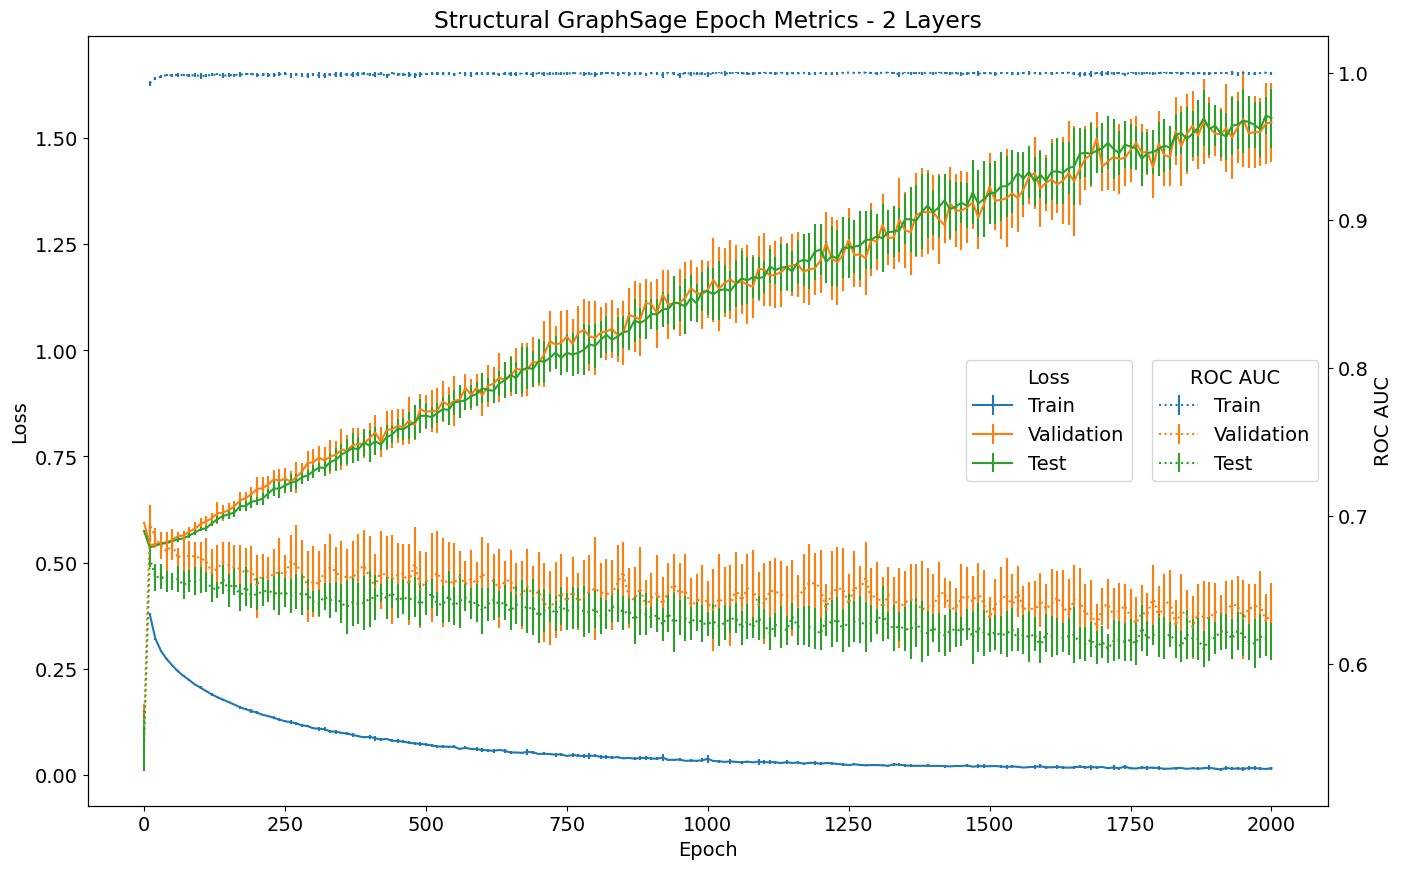

In [16]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Structural GraphSage Epoch Metrics - {n_layers_graph_sage} Layers')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/citeseer/structural_omega_graphsage_cossim_training_metrics_{n_layers_graph_sage}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [17]:
n_layers_list = range(1, 4)

In [18]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(dataset='citeseer', n_layers_graph_sage=n_layers_graph_sage)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_graph_sage] = auc_val
    mean_loss_val_dict[n_layers_graph_sage] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_graph_sage] = auc_val
    std_loss_val_dict[n_layers_graph_sage] = loss_val

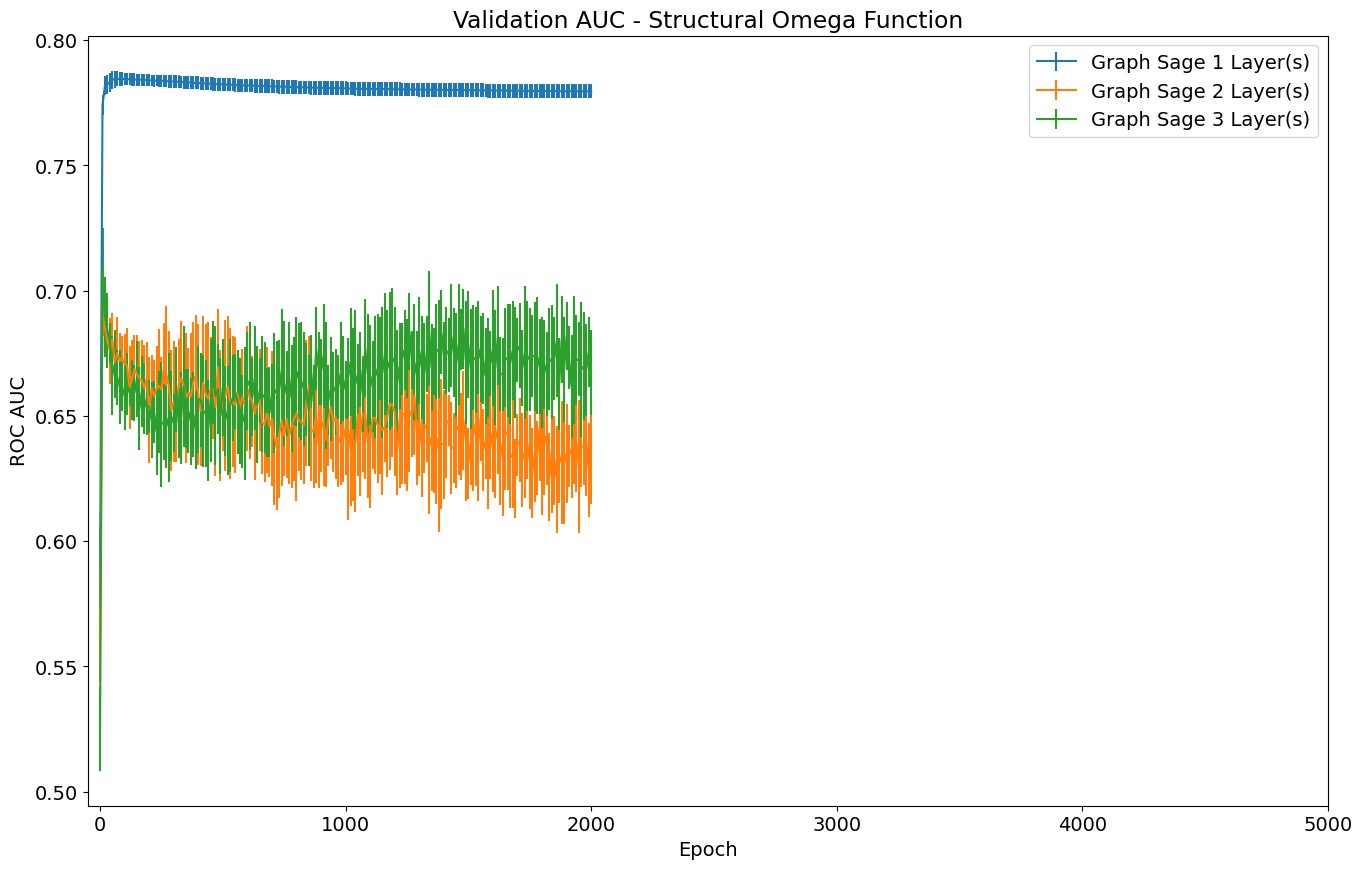

In [19]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)')

ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [20]:
n_layers_list = range(1, 4)

In [21]:
full_metrics = []
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(
        dataset='citeseer',
        n_layers_graph_sage=n_layers_graph_sage)
    metrics['n_layers_graph_sage'] = n_layers_graph_sage
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [22]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                     2.000000
epoch                  70.000000
loss_train              0.221366
loss_val                0.502667
loss_test               0.504976
auc_train               1.000000
auc_val                 0.789516
auc_test                0.753703
n_layers_graph_sage     1.000000
Name: 409, dtype: float64

In [23]:
best_model_metrics.to_json('models/structural_omega_grapn_sage_cossim/citeseer/best_model_info.json')